# Robust Neural Network: 2D toy example

In this example, we train a simple network that is robust to adversarial noise. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

In [2]:
# random points at least 2r apart
m = 50
np.random.seed(1)
x = [np.random.uniform(size=(2))]
r = 0.08
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
r = 0.06 
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

## Baseline: cross entropy loss

In [3]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data[0])

0.0009319512755610049


### Visualization: learned baseline classifier 

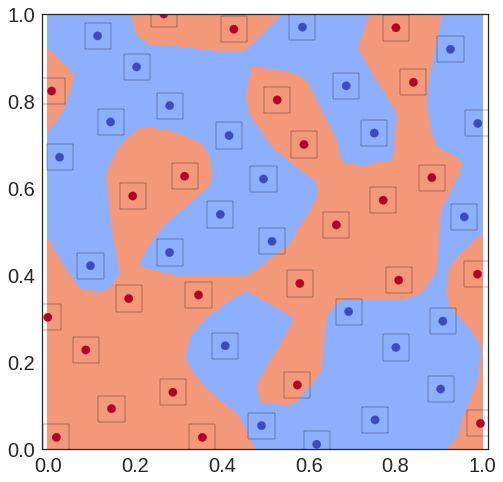

In [4]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

## Robust Neural Network

In [15]:
import sys
sys.path.append("../")
from convex_adversarial import robust_loss

torch.manual_seed(1)
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    robust_ce, robust_err = robust_loss(net, epsilon, Variable(X), Variable(y))
    l2 = nn.CrossEntropyLoss()(net(Variable(X)), Variable(y))
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()

print(l2.data[0], robust_ce.data[0], robust_err[0])

0.007619600743055344 0.08466241508722305 0.0


### Visualization: learned robust classifier

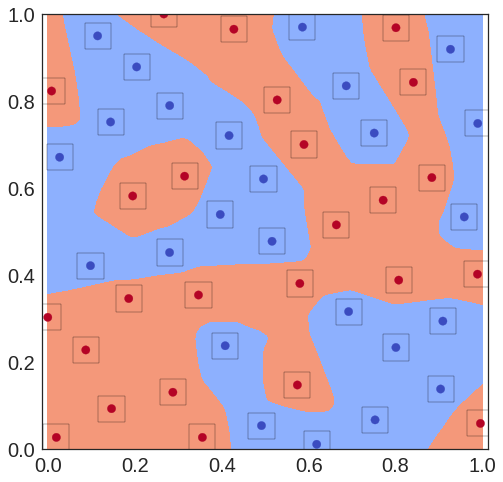

In [16]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))